# Solution 4.1: FEM for a rod
In this tutorial we will learn how to define the FEM to solve a rod subject to axial loading. The equation of motion of a rod is given by the following PDE:

$$ \rho A \frac{\partial^2 u(x,t)}{\partial t^2} - EA \frac{\partial^2u(x,t)}{\partial x^2} = q(x) $$

We consider that the rod has the following properties:

- Length of $L = 3$ $m$
- Fixed at $x=0$, that means $u(0,t) = 0 \forall t $
- The rod is at rest initially, $u(x,0) = 0$ and $\dot{u}(x,0) = 0$
- A dynamic point load $P=10e3 \cdot \sin(2\pi t)$ $N$ is applied at $x=L$
- $\rho = 8.0e3$ $kg/m^3$
- $A = 0.01$ $m^2$
- $E = 2.1e9$ $Pa$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L = 3
u0 = 0
u0_dt2 = 0
def P(t):
    return 10e3*np.sin(2*np.pi*t)
rho = 8.0e3
rho2 = 8.0e4
A = 1e-2
E = 2.1e9


## Step 1: discretize the domain
We consider a discretization made out of $n_e = 5$ elements equally spaced.

In [2]:
ne = 5
nn = ne + 1
xn = np.linspace(0, L, nn)

Let's plot the discretization

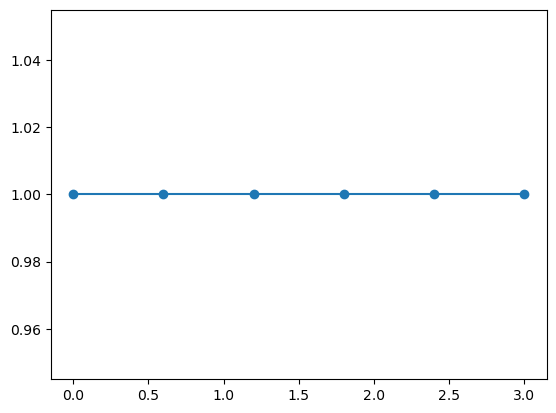

In [3]:
nodes = (xn, np.ones(nn))
plt.figure()
plt.plot(nodes[0], nodes[1],"o-");

We will need the information of the element-nodes connectivity, that is the nodes attached to each element. 

In [4]:
elem_nodes = []
for ie in np.arange(0,ne):
    elem_nodes.append([ie, ie+1])

This will give us a table with the index of the nodes attached to each element:

In [5]:
dicts = {}
for i in np.arange(0,ne):
    dicts[i] = elem_nodes[i]
print ("{:<18} {:<16} {:<16}".format('Element','Node-1','Node-2'))
for k,v in dicts.items():
    print("{:<18} {:<16} {:<16}".format(str(k), str(v[0]), str(v[1])))

Element            Node-1           Node-2          
0                  0                1               
1                  1                2               
2                  2                3               
3                  3                4               
4                  4                5               


## Step 2: define the shape functions
Here we assume that the displacement can be well captured by a piece-wise lienar function, so we make the modeling choice of selecting linear shape functions. 

For each element, the shape functions associated to node 1 and 2 are to be defined by:

$$ N_1^k = \frac{x_2-x}{h}, \quad N_1^{'k} = \frac{-1}{h} $$
$$ N_2^k = \frac{x-x_1}{h}, \quad N_2^{'k} = \frac{1}{h} $$

where $h=x_2-x_1$. Since all the nodes are equally distributed: $h=\frac{L}{N}$.

In [6]:
h = L/ne
N = []
dN = []
for ie in np.arange(0,ne):
    nodes = elem_nodes[ie]
    print(nodes)
    xe = xn[nodes]
    N.append([lambda x: (xe[1]-x)/h, lambda x: (x-xe[0])/h])
    dN.append([lambda x: -1/h + 0.0*x, lambda x: 1/h + 0.0*x])

[0, 1]
[1, 2]
[2, 3]
[3, 4]
[4, 5]


Let's see how these functions look like:

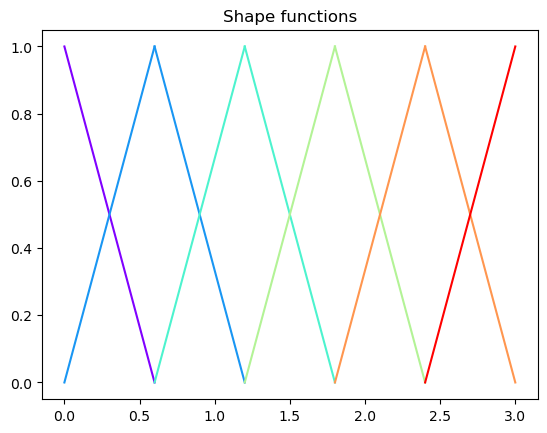

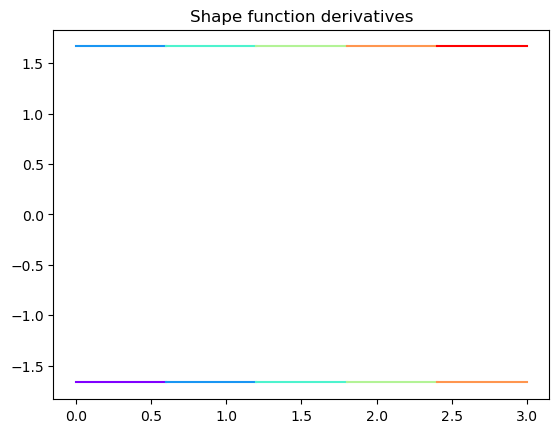

In [7]:
plt.figure()
color = iter(plt.cm.rainbow(np.linspace(0,1,ne+1)))
c=next(color)
for ie in np.arange(0,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    # Manage color scheme
    prev=c
    c=next(color)
    p=[prev,c]
    for i in np.arange(0,len(nodes)):
        plt.plot(xe,N[ie][i](xe),c=p[i])
plt.title("Shape functions")

plt.figure()
color = iter(plt.cm.rainbow(np.linspace(0,1,ne+1)))
c=next(color)
for ie in np.arange(0,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    # Manage color scheme
    prev=c
    c=next(color)
    p=[prev,c]
    for i in np.arange(0,len(nodes)):
        plt.plot(xe,dN[ie][i](xe),c=p[i])
plt.title("Shape function derivatives");

Note that here we are storing four functions at each element. This is not affordable for large systems. To be more efficient, FEM codes typically use an isoparametric element where the functions and derivatives are defined, and apply the corresponding transformations when performing the integrals. This approach is not covered in this tutorial. 

## Step 3: computation of the elemental matrices
In the theory we have seen that the mass and stiffness matrices for the rod problem can be computed as:

$$ M_{a,b}^k = \int_{x_a}^{x_b} \rho A N_a^k(x)N_b^{k}(x)dx $$
$$ K_{a,b}^k = \int_{x_a}^{x_b} E A N_a^{'k}(x)N_b^{'k}(x)dx $$

Here we can use the two approaches to compute these matrices: symbolically or numerically.

### Symbolic computation of the integral:
Here we make use of the capabilities of Python to perform symbolic operations. In that case we perform a symbolic integral with respect to the variable $x$, and we evaluate the integral between the element nodes. In Python symbolic operations can be done using the SymPy package. 

For more information see: https://docs.sympy.org/latest/index.html

In [8]:
import sympy as smp
x = smp.Symbol('x')
M_k_sym = []
for ie in np.arange(0,ne): # Loop over elements, get nodes attached to elements
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    M_k_sym.append(np.zeros((2,2))) # Construct local matrix, fill it below
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            eqn = rho*A*N[ie][i](x)*N[ie][j](x)
            M_k_sym[ie][i,j] = smp.integrate(eqn,(x, xe[0], xe[1]))

We know that the elemental mass matrix should be:

$$ {M}^k = \frac{\rho A h}{6} \begin{bmatrix} 2 & 1 \\ 1 & 2 \end{bmatrix} = \begin{bmatrix} 16 & 8 \\ 8 & 16 \end{bmatrix} $$

and we see that the computed matrices give the desired result:

In [9]:
print(M_k_sym[0])

[[16.  8.]
 [ 8. 16.]]


-----------------------------------------------------------------------------------------------------
**Problem:** Do the same operations for the stiffnes matrix and check that you get the same result as the one given in the theory lessons.

-----------------------------------------------------------------------------------------------------

The elemental stiffness matrix should be: 

$$ {K}^k = \frac{EA}{h} \begin{bmatrix} 1 & -1 \\ 1 & -1 \end{bmatrix} = 3.5e7 \begin{bmatrix} 1 & -1 \\ -1 & 1 \end{bmatrix} $$

In [10]:
# Implement the symbolic computation of the integrals for the stiffness matrix here
x = smp.Symbol('x')
K_k_sym = []
for ie in np.arange(0,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    K_k_sym.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            eqn = E*A*dN[ie][i](x)*dN[ie][j](x)
            K_k_sym[ie][i,j] = smp.integrate(eqn,(x, xe[0], xe[1]))
print(K_k_sym[0])

[[ 35000000. -35000000.]
 [-35000000.  35000000.]]


### Numerical computation of the integral:
The symbolic computation of an integral is very computationally expensive, and not advisable for large matrices. An alternative is to perform a numerical integration using quadrature formulas. 

Here we will use a quadrature rule that approximates the integral as 

$$ \int f(x) dx \approx \sum_{q=1}^{n_q} f(x_q)w_q $$

where $n_q$ is the number of quadrature points and $w_q$ is the quadrature point weight. The number of quadrature points will determine the accuracy of the integral. For instance, in a Gauss quadrature rule, a quadrature with $n_q$ points can integrate exactly functions of order $2n_q -1$. In our case, the mass matrix will be second order, since we have the product of two linear shape functions. Therefore, we need at least two quadratue points. This will be internally handled by Python when we call the function `quad` from the SciPy integration package. 

NOTE: the function `quad` from SciPy returns a tuple: (integrand value, estimated absolute error), hence the `[0]` is added at the end of the last line as we are only interested in the value. 

For more information see: https://docs.scipy.org/doc/scipy/tutorial/integrate.html and https://docs.scipy.org/doc/scipy/reference/index.html#

In [11]:
del x   # need to remove the symbolic x-variable when switching to scipy (only once)

In [12]:
import scipy.integrate as scp
M_k_num = []
for ie in np.arange(0,2):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    M_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return rho*A*N[ie][i](x)*N[ie][j](x)
            M_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]

for ie in np.arange(2,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    M_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return rho2*A*N[ie][i](x)*N[ie][j](x)
            M_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]

M_k_num[4][1,1] = M_k_num[4][1,1] + 1e3

Again, we display the matrix value to ensure that it is well computed:

In [13]:
print(M_k_num[0])
print("Rounding errors for numerical integration: "+str(abs(M_k_num[0]-M_k_sym[0])[0,0])) #= machine precision just

[[16.  8.]
 [ 8. 16.]]
Rounding errors for numerical integration: 1.7763568394002505e-15


Note that, since it is a numerical operation, we get rounding errors This is why the values are not exact integers as obtained with the symbolic computation.

We do the same operation for the stiffness matrix.

In [14]:
K_k_num = []
for ie in np.arange(0,2):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    K_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return E*A*dN[ie][i](x)*dN[ie][j](x)
            K_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]

for ie in np.arange(2,ne):
    nodes = elem_nodes[ie]
    xe = xn[nodes]
    K_k_num.append(np.zeros((2,2)))
    for i in np.arange(0,len(nodes)):
        for j in np.arange(0,len(nodes)):
            def eqn(x):
                return E*A*dN[ie][i](x)*dN[ie][j](x) + E*A*dN[ie][i](x)*N[ie][j](x)
            K_k_num[ie][i,j] = scp.quad(eqn, xe[0], xe[1])[0]

In [15]:
print(K_k_num[0])

[[ 35000000. -35000000.]
 [-35000000.  35000000.]]


## Step 4: global assembly
To construct the global matrices we add all the elemental contributions to the corresponding nodes.

In [16]:
M = np.zeros(nn*nn)
K = np.zeros(nn*nn)
for ie in np.arange(0,ne): # Loop over elements
    nodes = np.array(elem_nodes[ie])
    for i in np.arange(0, 2): # Loop over nodes
        for j in np.arange(0, 2):
            ij = nodes[i] + nodes[j]*nn
            M[ij] = M[ij] + M_k_num[ie][i,j]
            K[ij] = K[ij] + K_k_num[ie][i,j]

# Reshape the global matrix from a 1-dimensional array to a 2-dimensional array
M = M.reshape((nn, nn))
K = K.reshape((nn, nn))

Now we have the global mass and stiffness matrices:

In [17]:
print(M)
print(K)

[[  16.    8.    0.    0.    0.    0.]
 [   8.   32.    8.    0.    0.    0.]
 [   0.    8.  176.   80.    0.    0.]
 [   0.    0.   80.  320.   80.    0.]
 [   0.    0.    0.   80.  320.   80.]
 [   0.    0.    0.    0.   80. 1160.]]
[[ 35000000.         -35000000.                 0.
          0.                 0.                 0.        ]
 [-35000000.          70000000.         -35000000.
          0.                 0.                 0.        ]
 [        0.         -35000000.          59500000.
  -24500000.                 0.                 0.        ]
 [        0.                 0.         -45499999.99999999
   69999999.99999999 -24499999.99999999         0.        ]
 [        0.                 0.                 0.
  -45499999.99999999  70000000.         -24500000.00000001]
 [        0.                 0.                 0.
          0.         -45500000.00000001  45500000.00000001]]


In the right-hand-side, we will have a vector that accounts for the external forces. In that case, we have a point load at the last node, so we define the global vector directly as

In [18]:
def Q(t):
    return np.append(np.zeros((nn-1,1)), P(t))

We just need to apply the boundary conditions and we'll be set to solve.

To apply the boundary conditions, we will remove the rows associated to the fixed DOFs and add the contribution to the right-hand-side. First, we identify the free and fixed DOFs.

In [19]:
fixed_dofs = np.array([0])
free_dofs = np.arange(0,nn)
free_dofs = np.delete(free_dofs, fixed_dofs)    # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = free_dofs[:, np.newaxis]
fy = free_dofs[np.newaxis, :]
bx = fixed_dofs[:, np.newaxis]
by = fixed_dofs[np.newaxis, :]

We can re-order the matrices and vectors in blocks, such that it's easy to operate with the blocks corresponding with the fixed DOFs. We'll use the notation $_I$ to designate an interior DOF and $_B$ to designate a boundary node. 

$$ \begin{bmatrix} \bold{M}_{II} & \bold{M}_{IB} \\ \bold{M}_{BI} &\bold{M}_{BB} \end{bmatrix}, \quad \begin{bmatrix} \bold{K}_{II} & \bold{K}_{IB} \\ \bold{K}_{BI} &\bold{K}_{BB} \end{bmatrix}, \quad \begin{bmatrix} \bold{Q}_{I}  \\ \bold{Q}_{B}  \end{bmatrix} $$



In [20]:
Mii = M[fx, fy]
Mib = M[fx, by]
Mbi = M[bx, fy]
Mbb = M[bx, by]

Kii = K[fx, fy]
Kib = K[fx, by]
Kbi = K[bx, fy]
Kbb = K[bx, by]

Now operating with the different blocks, we can get a system of ODEs for the free DOFs, which is given by: 

$$ \bold{M}_{II}\bold{\ddot{u}}_I + \bold{K}_{II} \bold{u}_I = \bold{Q}_I - \bold{M}_{IB}\bold{\ddot{u}}_B - \bold{K}_{IB} \bold{u}_B $$

In [21]:
ub = np.array([u0])
ub_dt2 = np.array([u0_dt2])
RHS = -Mib*ub_dt2-Kib*ub

## Step 5: solving the ODE
At this point we have all the information to solve the ODE for each DOF. We can use what we learned in the previous modules.

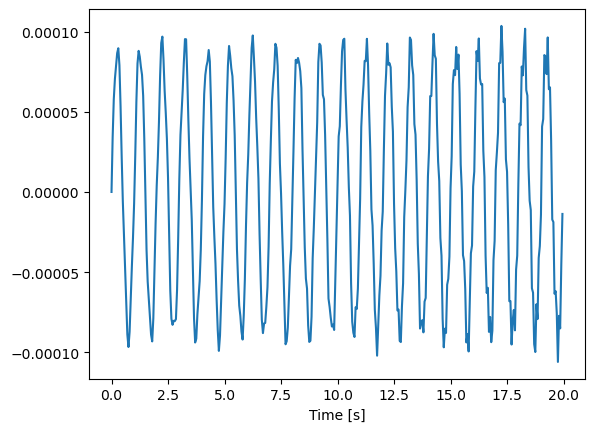

In [22]:
# Construct a matrix to reshape Q 
R = np.identity(nn)
R = R[fx, 0:nn]

# Set Dimensions and initial conditions of state vector
nfdofs = len(free_dofs)
udofs = np.arange(0, nfdofs)
vdofs = np.arange(nfdofs, 2*nfdofs)
q0 = np.zeros((2*nfdofs))

# Time span (output purposes)
tf = 20
tspan = np.arange(0, tf, 0.05)

# Solve
def odefun(t, q):
    return np.append(q[vdofs],
                     np.linalg.solve(Mii, (np.dot(R, Q(t)) + RHS - np.dot(Kii, q[udofs]).reshape(-1, 1)))).tolist()
sol = scp.solve_ivp(fun=odefun, t_span=[tspan[0], tspan[-1]], y0=q0, t_eval=tspan)  

# Plot results -- shown here for 1 node
plt.figure()
plt.plot(sol.t,sol.y[1])
plt.xlabel('Time [s]');